In [1]:
!pip install datasets tokenizers scikit-learn matplotlib ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.8 MB/s eta 0:00:00


# Load Data from XNLI Dataset

In [2]:
# load english data
from datasets import load_dataset
import pandas as pd

def load_xnli_en():
    xnli_en = load_dataset("xnli", "en")
    def combine_text(example):
        return {
            "text": example["premise"] + " [SEP] " + example["hypothesis"],
            "label": example["label"]
        }
    en_data = xnli_en["train"].map(combine_text)
    return pd.DataFrame(en_data)[["text", "label"]]

df_en = load_xnli_en()

In [3]:
# load Vietnamese data
def load_xnli_vi():
    xnli_vi = load_dataset("xnli", "vi")
    def combine_text(example):
        return {
            "text": example["premise"] + " [SEP] " + example["hypothesis"],
            "label": example["label"]
        }
    vi_data = xnli_vi["train"].map(combine_text)
    return pd.DataFrame(vi_data)[["text", "label"]]

df_vi = load_xnli_vi()

# BPE

In [4]:
# Train the BPE tokenizer function
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence as NormalizerSequence

def train_bpe_tokenizer(texts, vocab_size=10000, save_path="bpe_tokenizer_en.json"):
    with open("bpe_train.txt", "w", encoding="utf-8") as f:
        for line in texts:
            f.write(line + "\n")

    tokenizer = Tokenizer(BPE())
    tokenizer.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
    tokenizer.train(["bpe_train.txt"], trainer)
    tokenizer.save(save_path)
    return tokenizer


In [5]:
# Word tokenization Text → Add the tokens_str column
def tokenize_with_method(df, tokenizer_obj, method_name):
    df_copy = df.copy()
    df_copy[f"tokens_str_{method_name}"] = df_copy["text"].apply(
        lambda x: " ".join(tokenizer_obj.encode(x).tokens)
    )
    return df_copy

In [6]:
# Draw the Zipf curve
from collections import Counter
import matplotlib.pyplot as plt

def plot_zipf(df_tokens, method_name):
    token_counts = Counter()
    for text in df_tokens:
        token_counts.update(text.split())

    sorted_tokens = token_counts.most_common()
    ranks = list(range(1, len(sorted_tokens) + 1))
    freqs = [freq for _, freq in sorted_tokens]

    plt.figure(figsize=(8, 5))
    plt.loglog(ranks, freqs)
    plt.title(f"Zipf Curve - {method_name}")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [7]:
# Construct the TF-IDF Logistic Regression classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def run_tfidf_lr(df, tokens_str_column):
    X_texts = df[tokens_str_column]
    y = df["label"]

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(X_texts)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"[{tokens_str_column}] Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred, digits=4))
    return acc


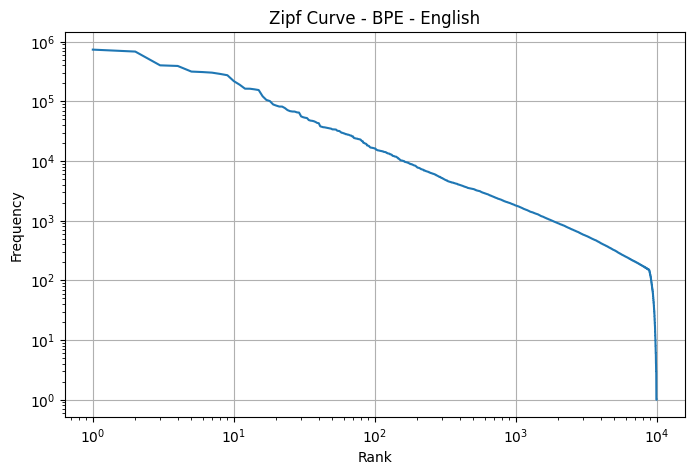

[tokens_str_bpe] Accuracy: 0.4415
              precision    recall  f1-score   support

           0     0.4283    0.4705    0.4484     26142
           1     0.4188    0.4119    0.4153     26314
           2     0.4819    0.4423    0.4613     26085

    accuracy                         0.4415     78541
   macro avg     0.4430    0.4416    0.4417     78541
weighted avg     0.4429    0.4415    0.4416     78541



In [8]:
# english BPE
# Step 1: load data 
df_en = load_xnli_en()

# Step 2: Train the BPE tokenizer
bpe_tokenizer = train_bpe_tokenizer(df_en["text"], vocab_size=10000)

# Step 3: word tokenization
df_bpe = tokenize_with_method(df_en, bpe_tokenizer, "bpe")

# Step 4: Draw the Zipf curve
plot_zipf(df_bpe["tokens_str_bpe"], "BPE - English")

# Step 5: TF-IDF + Logistic Regression
acc_clean_en_bpe = run_tfidf_lr(df_bpe, "tokens_str_bpe")


In [9]:
import random

# Add Noise Function: Randomly replace a certain proportion of characters in the text to simulate OCR or spelling mistakes for English.
def add_typo_noise_English(text, error_rate=0.05):
    chars = list(text)
    for i in range(len(chars)):
        if chars[i].isalpha() and random.random() < error_rate:
            chars[i] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)


In [10]:
# Add typo noise to English
df_en_bpe_noisy = df_en.copy()
df_en_bpe_noisy["text"] = df_en_bpe_noisy["text"].apply(lambda x: add_typo_noise_English(x, error_rate=0.05))

# Tokenize noisy text
df_bpe_noisy_en = tokenize_with_method(df_en_bpe_noisy, bpe_tokenizer, "bpe_noisy")

# Get noisy accuracy
acc_noisy_en_bpe = run_tfidf_lr(df_bpe_noisy_en, "tokens_str_bpe_noisy")

# Calculate drop using saved clean accuracy
drop_en_bpe = acc_clean_en_bpe - acc_noisy_en_bpe
print(f"Accuracy of English BPE model reduces: {drop_en_bpe * 100:.2f}%")

[tokens_str_bpe_noisy] Accuracy: 0.4133
              precision    recall  f1-score   support

           0     0.3917    0.4191    0.4049     26142
           1     0.3962    0.3923    0.3942     26314
           2     0.4561    0.4286    0.4419     26085

    accuracy                         0.4133     78541
   macro avg     0.4146    0.4133    0.4137     78541
weighted avg     0.4146    0.4133    0.4136     78541

Accuracy of English BPE model reduces: 2.82%


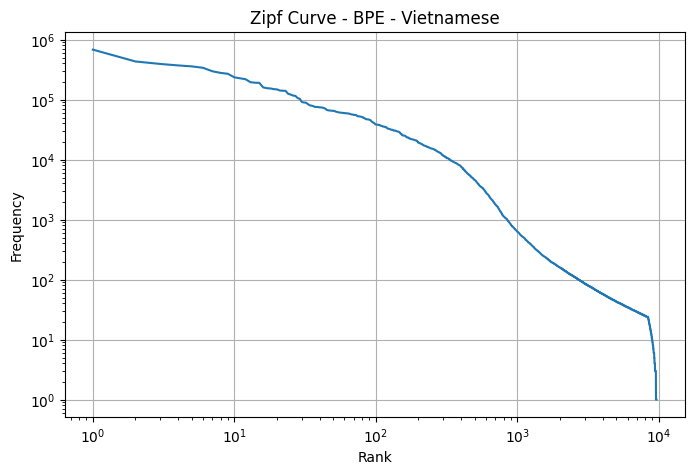

[tokens_str_bpe] Accuracy: 0.4222
              precision    recall  f1-score   support

           0     0.4190    0.4598    0.4384     26142
           1     0.4056    0.4005    0.4031     26314
           2     0.4442    0.4065    0.4245     26085

    accuracy                         0.4222     78541
   macro avg     0.4229    0.4223    0.4220     78541
weighted avg     0.4229    0.4222    0.4220     78541



In [11]:
# Vietnamese BPE
bpe_tokenizer_vi = train_bpe_tokenizer(df_vi["text"], vocab_size=10000, save_path="bpe_tokenizer_vi.json")

df_vi_bpe = tokenize_with_method(df_vi, bpe_tokenizer_vi, "bpe")

plot_zipf(df_vi_bpe["tokens_str_bpe"], "BPE - Vietnamese")

acc_clean_vi_bpe = run_tfidf_lr(df_vi_bpe, "tokens_str_bpe")


In [12]:
import random

VIETNAMESE_CHARS = "aăâbcdđeêghiklmnoôơpqrstuưvxy" \
                   "AĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXY" \
                   "áàảãạắằẳẵặấầẩẫậéèẻẽẹếềểễệ" \
                   "íìỉĩịóòỏõọốồổỗộớờởỡợúùủũụ" \
                   "ứừửữựýỳỷỹỵ" \
                   "ÁÀẢÃẠẮẰẲẴẶẤẦẨẪẬÉÈẺẼẸẾỀỂỄỆ" \
                   "ÍÌỈĨỊÓÒỎÕỌỐỒỔỖỘỚỜỞỠỢÚÙỦŨỤ" \
                   "ỨỪỬỮỰÝỲỶỸỴ"

def add_typo_noise_vietnamese(text, error_rate=0.05):
    """
    Randomly replace a proportion of characters (including Vietnamese diacritics)
    to simulate OCR or spelling errors.
    """
    chars = list(text)
    for i in range(len(chars)):
        if chars[i].isalpha() and random.random() < error_rate:
            chars[i] = random.choice(VIETNAMESE_CHARS)
    return "".join(chars)


In [13]:
# Add typo noise to Vietnamese
df_vi_noisy = df_vi.copy()
df_vi_noisy["text"] = df_vi_noisy["text"].apply(lambda x: add_typo_noise_vietnamese(x, error_rate=0.05))

df_noisy_vi_bpe = tokenize_with_method(df_vi_noisy, bpe_tokenizer_vi, "bpe_noisy")

print("After adding noise to Vietnamese BPE model:")
acc_noisy_vi_bpe = run_tfidf_lr(df_noisy_vi_bpe, "tokens_str_bpe_noisy")

drop_vi_bpe = acc_clean_vi_bpe - acc_noisy_vi_bpe
print(f"\n Accuracy of Vietnamese BPE model reduces: {round(drop_vi_bpe * 100, 2)}%")

After adding noise to Vietnamese BPE model:
[tokens_str_bpe_noisy] Accuracy: 0.4045
              precision    recall  f1-score   support

           0     0.3940    0.4163    0.4048     26142
           1     0.3884    0.3832    0.3858     26314
           2     0.4329    0.4143    0.4234     26085

    accuracy                         0.4045     78541
   macro avg     0.4051    0.4046    0.4047     78541
weighted avg     0.4051    0.4045    0.4046     78541


 Accuracy of Vietnamese BPE model reduces: 1.77%


# WordPiece

In [14]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase, NFD, StripAccents, Sequence as NormalizerSequence

def train_wordpiece_tokenizer(texts, vocab_size=10000, save_path="wordpiece_tokenizer.json"):
    with open("wp_train.txt", "w", encoding="utf-8") as f:
        for line in texts:
            f.write(line + "\n")

    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    tokenizer.normalizer = NormalizerSequence([NFD(), Lowercase(), StripAccents()])
    tokenizer.pre_tokenizer = Whitespace()

    trainer = WordPieceTrainer(
        vocab_size=vocab_size,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
    )

    tokenizer.train(["wp_train.txt"], trainer)
    tokenizer.save(save_path)

    return tokenizer

In [15]:
# Train the English WordPiece tokenizer
wordpiece_tokenizer_en = train_wordpiece_tokenizer(df_en["text"], save_path="wordpiece_tokenizer_en.json")

# Train the Vietnamese WordPiece tokenizer
wordpiece_tokenizer_vi = train_wordpiece_tokenizer(df_vi["text"], save_path="wordpiece_tokenizer_vi.json")

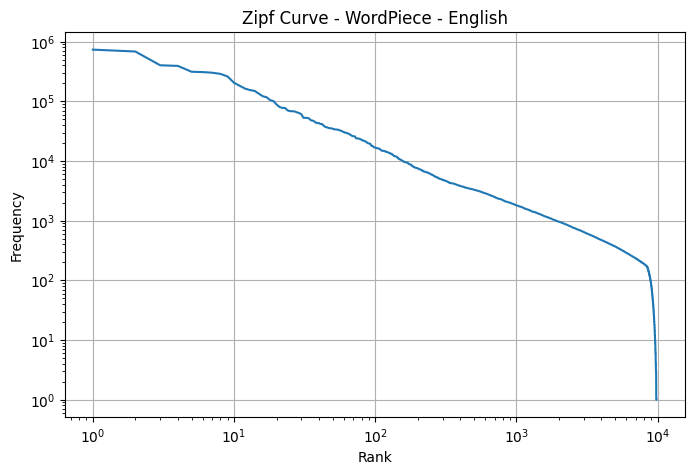

[tokens_str_wordpiece] Accuracy: 0.4435
              precision    recall  f1-score   support

           0     0.4334    0.4785    0.4549     26142
           1     0.4197    0.4097    0.4146     26314
           2     0.4809    0.4424    0.4609     26085

    accuracy                         0.4435     78541
   macro avg     0.4447    0.4435    0.4435     78541
weighted avg     0.4446    0.4435    0.4434     78541



In [16]:
# Load the WordPiece tokenizer
from tokenizers import Tokenizer
wordpiece_tokenizer_en = Tokenizer.from_file("wordpiece_tokenizer_en.json")

# Word tokenization generates tokens_str_wordpiece
df_wp_en = tokenize_with_method(df_en, wordpiece_tokenizer_en, "wordpiece")
plot_zipf(df_wp_en["tokens_str_wordpiece"], "WordPiece - English")

acc_clean_en_wp = run_tfidf_lr(df_wp_en, "tokens_str_wordpiece")

In [17]:
# add noise
df_wp_en_noisy = df_en.copy()
df_wp_en_noisy["text"] = df_wp_en_noisy["text"].apply(lambda x: add_typo_noise_English(x, error_rate=0.05))

# Rework the new word tokenization using the WordPiece tokenizer for English
df_wp_en_noisy = tokenize_with_method(df_wp_en_noisy, wordpiece_tokenizer_en, "wordpiece_noisy")

acc_noisy_en_wp = run_tfidf_lr(df_wp_en_noisy, "tokens_str_wordpiece_noisy")
drop_en_wp = acc_clean_en_wp - acc_noisy_en_wp

print(f"\n WordPiece (English) Accuracy Drop: {round(drop_en_wp * 100, 2)}%")

[tokens_str_wordpiece_noisy] Accuracy: 0.4146
              precision    recall  f1-score   support

           0     0.3949    0.4208    0.4074     26142
           1     0.3998    0.3923    0.3960     26314
           2     0.4520    0.4308    0.4411     26085

    accuracy                         0.4146     78541
   macro avg     0.4156    0.4146    0.4149     78541
weighted avg     0.4155    0.4146    0.4148     78541


 WordPiece (English) Accuracy Drop: 2.89%


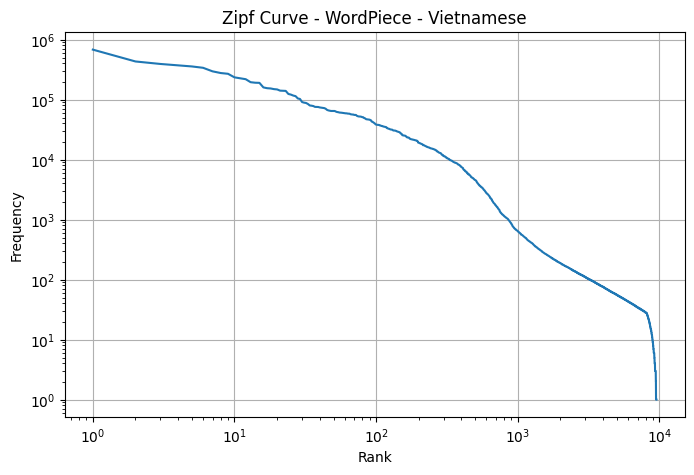

[tokens_str_wordpiece] Accuracy: 0.423
              precision    recall  f1-score   support

           0     0.4202    0.4612    0.4397     26142
           1     0.4084    0.4034    0.4059     26314
           2     0.4423    0.4045    0.4226     26085

    accuracy                         0.4230     78541
   macro avg     0.4236    0.4230    0.4227     78541
weighted avg     0.4236    0.4230    0.4227     78541



In [18]:
# Word tokenization generates tokens_str_wordpiece for Vietnamese
wordpiece_tokenizer_vi = train_wordpiece_tokenizer(df_vi["text"], save_path="wordpiece_tokenizer_vi.json")
df_wp_vi = tokenize_with_method(df_vi, wordpiece_tokenizer_vi, "wordpiece")
plot_zipf(df_wp_vi["tokens_str_wordpiece"], "WordPiece - Vietnamese")
acc_clean_vi_wp = run_tfidf_lr(df_wp_vi, "tokens_str_wordpiece")

In [19]:
# Rework the new word tokenization using the WordPiece tokenizer for Vietnamese
df_wp_vi_noisy = df_vi.copy()
df_wp_vi_noisy["text"] = df_wp_vi_noisy["text"].apply(lambda x: add_typo_noise_vietnamese(x, error_rate=0.05))

df_wp_vi_noisy = tokenize_with_method(df_wp_vi_noisy, wordpiece_tokenizer_vi, "wordpiece_noisy")

acc_noisy_vi_wp = run_tfidf_lr(df_wp_vi_noisy, "tokens_str_wordpiece_noisy")

drop_vi_wp = acc_clean_vi_wp - acc_noisy_vi_wp
print(f"\n WordPiece (Vietnamese) Accuracy Drop: {round(drop_vi_wp * 100, 2)}%")


[tokens_str_wordpiece_noisy] Accuracy: 0.4047
              precision    recall  f1-score   support

           0     0.3919    0.4121    0.4018     26142
           1     0.3920    0.3887    0.3903     26314
           2     0.4322    0.4134    0.4226     26085

    accuracy                         0.4047     78541
   macro avg     0.4053    0.4048    0.4049     78541
weighted avg     0.4053    0.4047    0.4049     78541


 WordPiece (Vietnamese) Accuracy Drop: 1.83%


# SentencePiece-BPE

In [20]:
!pip install sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
import sentencepiece as spm
import os

def train_sentencepiece_tokenizer(texts, model_prefix="spm_model", vocab_size=10000, model_type="bpe"):
    """
    Train the SentencePiece tokenizer (BPE or Unigram) to generate model and vocab files.
    """
    # Write into the training corpus
    input_file = f"{model_prefix}_train.txt"
    with open(input_file, "w", encoding="utf-8") as f:
        for line in texts:
            f.write(line.strip() + "\n")

    # train
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type=model_type,
        character_coverage=1.0,
        pad_id=0, unk_id=1, bos_id=2, eos_id=3,
        user_defined_symbols=["[SEP]"]
    )

    # Load trianed model
    sp = spm.SentencePieceProcessor()
    sp.load(f"{model_prefix}.model")
    return sp


In [22]:
def tokenize_with_sentencepiece(df, sp_model, method_name):
    df_copy = df.copy()
    df_copy[f"tokens_str_{method_name}"] = df_copy["text"].apply(
        lambda x: " ".join(sp_model.encode(x, out_type=str))
    )
    return df_copy

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_bpe_en_train.txt
  input_format: 
  model_prefix: sp_bpe_en
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_di

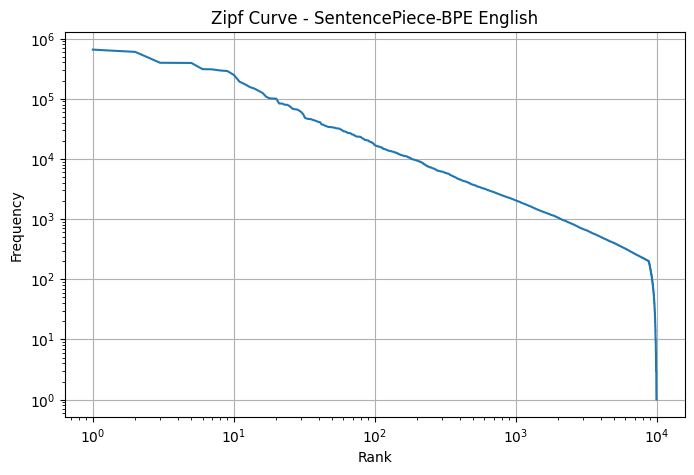

[tokens_str_sp_bpe] Accuracy: 0.4485
              precision    recall  f1-score   support

           0     0.4374    0.4808    0.4581     26142
           1     0.4265    0.4195    0.4229     26314
           2     0.4857    0.4455    0.4647     26085

    accuracy                         0.4485     78541
   macro avg     0.4499    0.4486    0.4486     78541
weighted avg     0.4498    0.4485    0.4485     78541

[tokens_str_sp_bpe_noisy] Accuracy: 0.4192
              precision    recall  f1-score   support

           0     0.3971    0.4236    0.4100     26142
           1     0.4019    0.3978    0.3998     26314
           2     0.4625    0.4363    0.4490     26085

    accuracy                         0.4192     78541
   macro avg     0.4205    0.4192    0.4196     78541
weighted avg     0.4204    0.4192    0.4195     78541

SentencePiece-BPE (English) Accuracy drop: 2.93%


In [23]:
# Train the SentencePiece-BPE tokenizer for English
sp_bpe_en = train_sentencepiece_tokenizer(df_en["text"], model_prefix="sp_bpe_en", model_type="bpe", vocab_size=10000)
df_sp_bpe_en = tokenize_with_sentencepiece(df_en, sp_bpe_en, "sp_bpe")

plot_zipf(df_sp_bpe_en["tokens_str_sp_bpe"], "SentencePiece-BPE English")

acc_clean_en_spbpe = run_tfidf_lr(df_sp_bpe_en, "tokens_str_sp_bpe")

# Add noise and train again
df_en_noisy = df_en.copy()
df_en_noisy["text"] = df_en_noisy["text"].apply(lambda x: add_typo_noise_English(x, error_rate=0.05))
df_sp_bpe_en_noisy = tokenize_with_sentencepiece(df_en_noisy, sp_bpe_en, "sp_bpe_noisy")
acc_noisy_en_spbpe  = run_tfidf_lr(df_sp_bpe_en_noisy, "tokens_str_sp_bpe_noisy")
drop_en_spbpe = acc_clean_en_spbpe - acc_noisy_en_spbpe
print(f"SentencePiece-BPE (English) Accuracy drop: {round(drop_en_spbpe*100, 2)}%")


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_bpe_vi_train.txt
  input_format: 
  model_prefix: sp_bpe_vi
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_dif

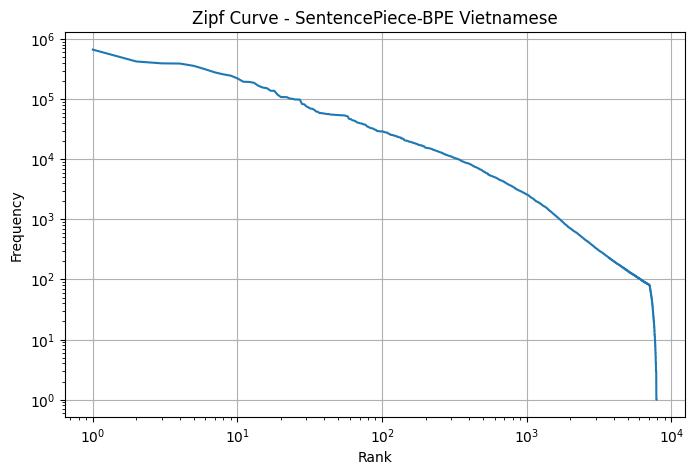

[tokens_str_sp_bpe] Accuracy: 0.4389
              precision    recall  f1-score   support

           0     0.4331    0.4799    0.4553     26142
           1     0.4232    0.4165    0.4198     26314
           2     0.4632    0.4205    0.4408     26085

    accuracy                         0.4389     78541
   macro avg     0.4398    0.4390    0.4386     78541
weighted avg     0.4398    0.4389    0.4386     78541

[tokens_str_sp_bpe_noisy] Accuracy: 0.4164
              precision    recall  f1-score   support

           0     0.4014    0.4272    0.4139     26142
           1     0.4014    0.3931    0.3972     26314
           2     0.4487    0.4291    0.4387     26085

    accuracy                         0.4164     78541
   macro avg     0.4172    0.4165    0.4166     78541
weighted avg     0.4171    0.4164    0.4165     78541


 SentencePiece-BPE (Vietnamese) Accuracy Drop: 2.25%


In [24]:
# Train the SentencePiece-BPE tokenizer for Vietnamese
sp_bpe_vi = train_sentencepiece_tokenizer(
    df_vi["text"],
    model_prefix="sp_bpe_vi",
    vocab_size=8000,
    model_type="bpe"
)

df_sp_bpe_vi = tokenize_with_sentencepiece(df_vi, sp_bpe_vi, "sp_bpe")
plot_zipf(df_sp_bpe_vi["tokens_str_sp_bpe"], "SentencePiece-BPE Vietnamese")

acc_clean_vi_spbpe = run_tfidf_lr(df_sp_bpe_vi, "tokens_str_sp_bpe")

# Add noise and train again
df_sp_bpe_vi_noisy = df_vi.copy()
df_sp_bpe_vi_noisy["text"] = df_sp_bpe_vi_noisy["text"].apply(lambda x: add_typo_noise_vietnamese(x, error_rate=0.05))

df_sp_bpe_vi_noisy = tokenize_with_sentencepiece(df_sp_bpe_vi_noisy, sp_bpe_vi, "sp_bpe_noisy")
acc_noisy_vi_spbpe = run_tfidf_lr(df_sp_bpe_vi_noisy, "tokens_str_sp_bpe_noisy")

drop_vi_spbpe = acc_clean_vi_spbpe - acc_noisy_vi_spbpe
print(f"\n SentencePiece-BPE (Vietnamese) Accuracy Drop: {round(drop_vi_spbpe * 100, 2)}%")


# SentencePiece-Unigram

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_unigram_en_train.txt
  input_format: 
  model_prefix: sp_unigram_en
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 


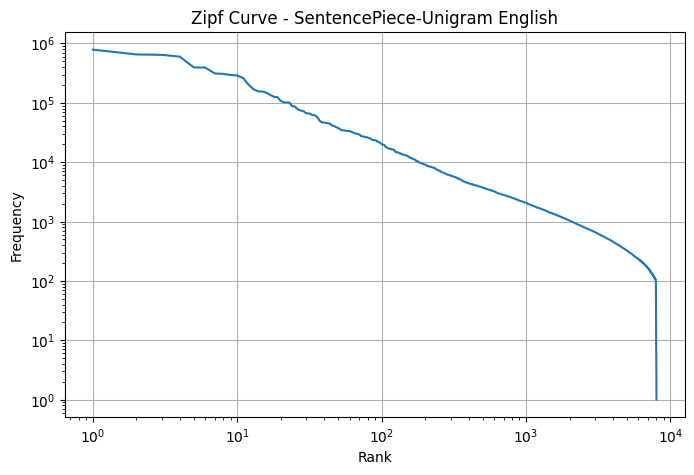

[tokens_str_sp_unigram] Accuracy: 0.4526
              precision    recall  f1-score   support

           0     0.4432    0.4887    0.4648     26142
           1     0.4309    0.4260    0.4284     26314
           2     0.4878    0.4432    0.4644     26085

    accuracy                         0.4526     78541
   macro avg     0.4540    0.4526    0.4526     78541
weighted avg     0.4539    0.4526    0.4525     78541

[tokens_str_sp_unigram_noisy] Accuracy: 0.4217
              precision    recall  f1-score   support

           0     0.4028    0.4345    0.4181     26142
           1     0.4078    0.4006    0.4041     26314
           2     0.4581    0.4301    0.4437     26085

    accuracy                         0.4217     78541
   macro avg     0.4229    0.4217    0.4220     78541
weighted avg     0.4228    0.4217    0.4219     78541


 SentencePiece-Unigram (English) Accuracy Drop: 3.09%


In [25]:
# Train the SentencePiece-Unigram tokenizer for english
sp_unigram_en = train_sentencepiece_tokenizer(
    df_en["text"],
    model_prefix="sp_unigram_en",
    vocab_size=8000,
    model_type="unigram"
)

df_sp_unigram_en = tokenize_with_sentencepiece(df_en, sp_unigram_en, "sp_unigram")
plot_zipf(df_sp_unigram_en["tokens_str_sp_unigram"], "SentencePiece-Unigram English")

acc_clean_en_spuni = run_tfidf_lr(df_sp_unigram_en, "tokens_str_sp_unigram")

# Add noise and train again
df_sp_unigram_en_noisy = df_en.copy()
df_sp_unigram_en_noisy["text"] = df_sp_unigram_en_noisy["text"].apply(lambda x: add_typo_noise_English(x, error_rate=0.05))
df_sp_unigram_en_noisy = tokenize_with_sentencepiece(df_sp_unigram_en_noisy, sp_unigram_en, "sp_unigram_noisy")

acc_noisy_en_spuni = run_tfidf_lr(df_sp_unigram_en_noisy, "tokens_str_sp_unigram_noisy")

drop_en_spuni = acc_clean_en_spuni - acc_noisy_en_spuni
print(f"\n SentencePiece-Unigram (English) Accuracy Drop: {round(drop_en_spuni * 100, 2)}%")

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: sp_unigram_vi_train.txt
  input_format: 
  model_prefix: sp_unigram_vi
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [SEP]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 


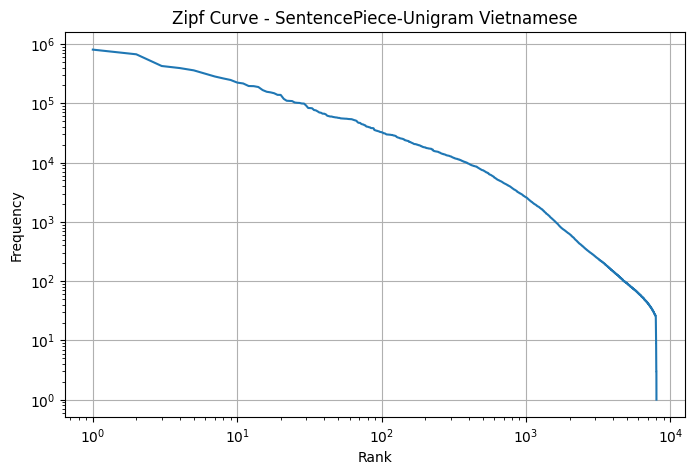

[tokens_str_sp_unigram] Accuracy: 0.4377
              precision    recall  f1-score   support

           0     0.4305    0.4764    0.4523     26142
           1     0.4239    0.4205    0.4222     26314
           2     0.4618    0.4163    0.4378     26085

    accuracy                         0.4377     78541
   macro avg     0.4387    0.4377    0.4375     78541
weighted avg     0.4387    0.4377    0.4374     78541

[tokens_str_sp_unigram_noisy] Accuracy: 0.4197
              precision    recall  f1-score   support

           0     0.4044    0.4315    0.4175     26142
           1     0.4045    0.3984    0.4014     26314
           2     0.4531    0.4294    0.4409     26085

    accuracy                         0.4197     78541
   macro avg     0.4206    0.4198    0.4199     78541
weighted avg     0.4206    0.4197    0.4199     78541


 SentencePiece-Unigram (Vietnamese) Accuracy Drop: 1.8%


In [26]:
# Train the SentencePiece-Unigram tokenizer for Vietnamese
sp_unigram_vi = train_sentencepiece_tokenizer(
    df_vi["text"],
    model_prefix="sp_unigram_vi",
    vocab_size=8000,
    model_type="unigram"
)
df_sp_unigram_vi = tokenize_with_sentencepiece(df_vi, sp_unigram_vi, "sp_unigram")
plot_zipf(df_sp_unigram_vi["tokens_str_sp_unigram"], "SentencePiece-Unigram Vietnamese")

acc_clean_vi_spuni = run_tfidf_lr(df_sp_unigram_vi, "tokens_str_sp_unigram")

# Add noise and train again
df_sp_unigram_vi_noisy = df_vi.copy()
df_sp_unigram_vi_noisy["text"] = df_sp_unigram_vi_noisy["text"].apply(lambda x: add_typo_noise_vietnamese(x, error_rate=0.05))
df_sp_unigram_vi_noisy = tokenize_with_sentencepiece(df_sp_unigram_vi_noisy, sp_unigram_vi, "sp_unigram_noisy")

acc_noisy_vi_spuni = run_tfidf_lr(df_sp_unigram_vi_noisy, "tokens_str_sp_unigram_noisy")

drop_vi_spuni = acc_clean_vi_spuni - acc_noisy_vi_spuni
print(f"\n SentencePiece-Unigram (Vietnamese) Accuracy Drop: {round(drop_vi_spuni * 100, 2)}%")

# Comparison

In [27]:
import pandas as pd

results = [
    ["BPE", "English", acc_clean_en_bpe, acc_noisy_en_bpe, drop_en_bpe],
    ["BPE", "Vietnamese", acc_clean_vi_bpe, acc_noisy_vi_bpe, drop_vi_bpe],
    ["WordPiece", "English", acc_clean_en_wp, acc_noisy_en_wp, drop_en_wp],
    ["WordPiece", "Vietnamese", acc_clean_vi_wp, acc_noisy_vi_wp, drop_vi_wp],
    ["SentencePiece-BPE", "English", acc_clean_en_spbpe, acc_noisy_en_spbpe, drop_en_spbpe],
    ["SentencePiece-BPE", "Vietnamese", acc_clean_vi_spbpe, acc_noisy_vi_spbpe, drop_vi_spbpe],
    ["SentencePiece-Unigram", "English", acc_clean_en_spuni, acc_noisy_en_spuni, drop_en_spuni],
    ["SentencePiece-Unigram", "Vietnamese", acc_clean_vi_spuni, acc_noisy_vi_spuni, drop_vi_spuni],
]

df_results = pd.DataFrame(results, columns=["Tokenizer", "Language", "Clean Acc", "Noisy Acc", "Drop (%)"])
df_results["Drop (%)"] = df_results["Drop (%)"].apply(lambda x: round(x * 100, 2))

print(df_results)


               Tokenizer    Language  Clean Acc  Noisy Acc  Drop (%)
0                    BPE     English   0.441515   0.413275      2.82
1                    BPE  Vietnamese   0.422238   0.404528      1.77
2              WordPiece     English   0.443463   0.414573      2.89
3              WordPiece  Vietnamese   0.423002   0.404719      1.83
4      SentencePiece-BPE     English   0.448517   0.419170      2.93
5      SentencePiece-BPE  Vietnamese   0.438917   0.416419      2.25
6  SentencePiece-Unigram     English   0.452566   0.421678      3.09
7  SentencePiece-Unigram  Vietnamese   0.437695   0.419730      1.80


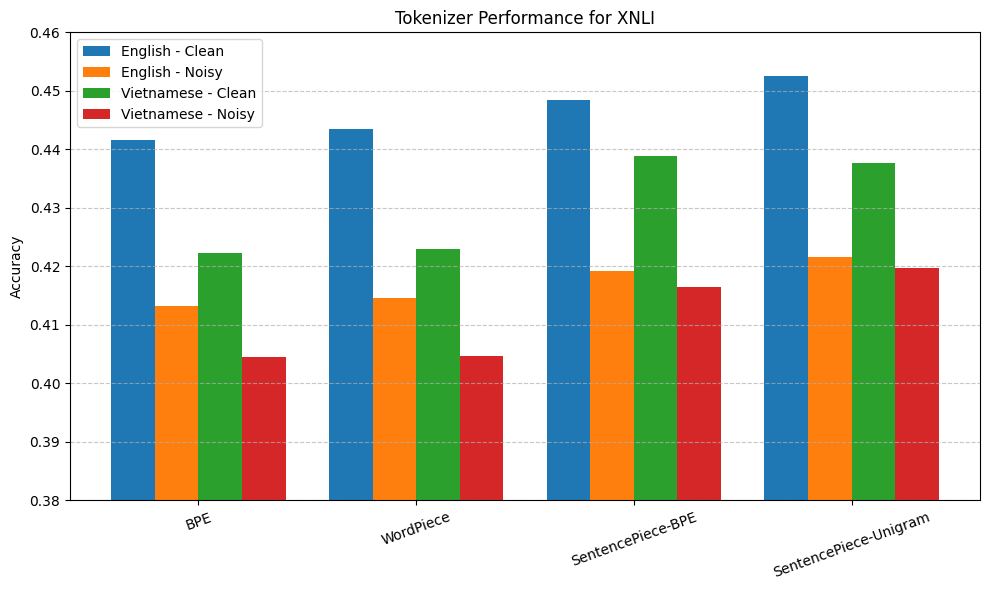

In [28]:
import matplotlib.pyplot as plt
import numpy as np

tokenizers = df_results["Tokenizer"].unique()
x = np.arange(len(tokenizers))

clean_en = df_results[df_results["Language"] == "English"]["Clean Acc"].values
noisy_en = df_results[df_results["Language"] == "English"]["Noisy Acc"].values
clean_vi = df_results[df_results["Language"] == "Vietnamese"]["Clean Acc"].values
noisy_vi = df_results[df_results["Language"] == "Vietnamese"]["Noisy Acc"].values

bar_width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*bar_width, clean_en, width=bar_width, label="English - Clean")
plt.bar(x - 0.5*bar_width, noisy_en, width=bar_width, label="English - Noisy")
plt.bar(x + 0.5*bar_width, clean_vi, width=bar_width, label="Vietnamese - Clean")
plt.bar(x + 1.5*bar_width, noisy_vi, width=bar_width, label="Vietnamese - Noisy")

plt.xticks(x, tokenizers, rotation=20)
plt.ylabel("Accuracy")
plt.title("Tokenizer Performance for XNLI")
plt.ylim(0.38, 0.46)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("accuracy_comparison_XNLI.png", dpi=300)
plt.show()
